# Imports/Setup

In [1]:
import polars as pl
import numpy as np
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
import matplotlib.pylab as plt
import cv2
import datashader as ds
import colorcet as cc
from hydra import initialize, compose

## Import Male Right Mesh data

In [2]:
imported_data =\
    np.load("E:\Geodesic-Path-Finder\Data\male right arm mesh data.npz")

# Get the 3D mesh data
mesh_verticies = imported_data["mesh_verticies"]
mesh_faces = imported_data["mesh_faces"]

# Get the uv data
uv_array = imported_data["uv_array"]

# Find the Area of the Mesh Faces

## Area of 3D Triangle
- $A = \frac{\mid\mid \vec{AB} \times \vec{AC} \mid\mid}{2}$
- For any triangle with points $A$, $B$, $C$.

In [3]:
def triangle_area(triangle: np.ndarray) -> float:
    '''
    Finds the area of an arbitrary triangle.

    Takes in the three points of any triangle and finds the area using half
    the magnitude of the cross product.

    Parameters
    ----------
    triangle : np.ndarray
        A 3xN array where the rows are the three points and the columns define
        the coordinates of the point in space.

    Returns
    -------
    area : float
        The area of the triangle. 
    '''
    # Extract the points of the triangle
    point_1 = triangle[0, :]
    point_2 = triangle[1, :]
    point_3 = triangle[2, :]

    # triangle vectors
    AB = point_2 - point_1
    AC = point_3 - point_1

    area = np.linalg.norm(np.cross(AB, AC))

    return area

## Make a list of all of the Mesh Face Areas

In [4]:
mesh_areas = []
for face in mesh_faces:
    triangle = np.array([
        mesh_verticies[face[0]],
        mesh_verticies[face[1]],
        mesh_verticies[face[2]]
        ])
    area = triangle_area(triangle)
    mesh_areas.append(area)

<Axes: >

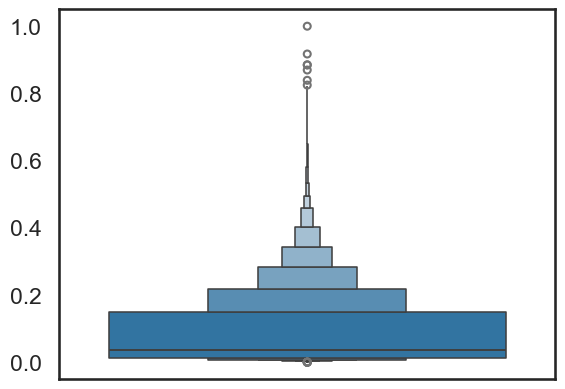

In [5]:
sns.boxenplot(data=mesh_areas / np.max(mesh_areas))

## Find the UV mapp areas

In [6]:
# Load in the text version of the model
mesh_data =\
    pl.read_csv(
        "E:\Geodesic-Path-Finder\Models\Male Right Arm UV Mapped as Text.txt",
        separator=' ', has_header=False,
        new_columns=["Type", "Point 1", "Point 2", "Point 3"],
        infer_schema_length=0)

# Split the input data into groups of v, vt, vn, and f for the
# vertex, UV (texture), Normal, and face data.
grouped_mesh_data = mesh_data.partition_by(["Type"], as_dict=True)

# Get the face data
face_data = grouped_mesh_data[("f",)]
# Split each column into its own table for the vertex, uv and normal
# of each point on a face.
split_face_data_1 = face_data.with_columns(
    pl.col("Point 1")
    .str.split_exact("/", 3)
    .struct.rename_fields(["vertex", "uv", "normal"])
    .alias("fields")
).unnest(
    "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")
split_face_data_1 = split_face_data_1.with_columns(
    pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal")

split_face_data_2 = face_data.with_columns(
    pl.col("Point 2")
    .str.split_exact("/", 3)
    .struct.rename_fields(["vertex", "uv", "normal"])
    .alias("fields")
).unnest(
    "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")
split_face_data_2 = split_face_data_2.with_columns(
    pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal")

split_face_data_3 = face_data.with_columns(
    pl.col("Point 3")
    .str.split_exact("/", 3)
    .struct.rename_fields(["vertex", "uv", "normal"])
    .alias("fields")
).unnest(
    "fields").drop("Type").drop("Point 1").drop("Point 2").drop("Point 3")
split_face_data_3 = split_face_data_3.with_columns(
    pl.col("vertex").cast(pl.Int32)
    ).with_columns(
        pl.col("uv").cast(pl.UInt32)
    ).drop("normal")

In [7]:
uv_areas = []
for i in range(len(split_face_data_1)):
    uv_1 = uv_array[split_face_data_1["uv"][i] - 1]
    uv_2 = uv_array[split_face_data_2["uv"][i]- 1]
    uv_3 = uv_array[split_face_data_3["uv"][i] - 1]

    triangle = np.array([
        uv_1,
        uv_2,
        uv_3
    ])
    area = triangle_area(triangle)
    if area > 0:
        uv_areas.append(area)

<Axes: >

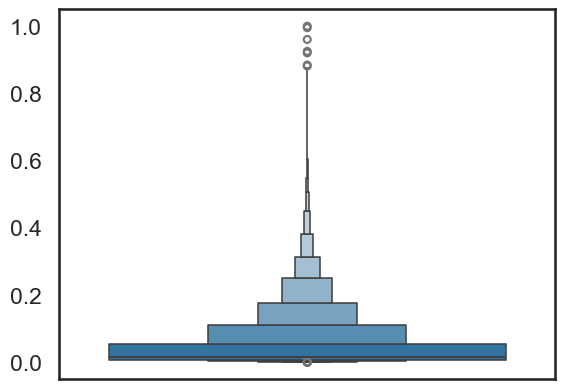

In [8]:
sns.boxenplot(data=uv_areas / np.max(uv_areas))

In [9]:
mesh_areas_table = pl.DataFrame(
    data={"Normalized Area": mesh_areas / np.max(mesh_areas)},
    schema={"Normalized Area": pl.Float64}
    ).with_columns(pl.lit("Mesh Area").alias("Mapping Type"))

uv_areas_table = pl.DataFrame(
    data={"Normalized Area": uv_areas / np.max(uv_areas)},
    schema={"Normalized Area": pl.Float64}
    ).with_columns(pl.lit("2D Mapped Area").alias("Mapping Type"))

area_table = pl.concat([mesh_areas_table, uv_areas_table])

Text(0.5, 1.0, 'Comparison of Mesh Areas to 2D Mapped Areas')

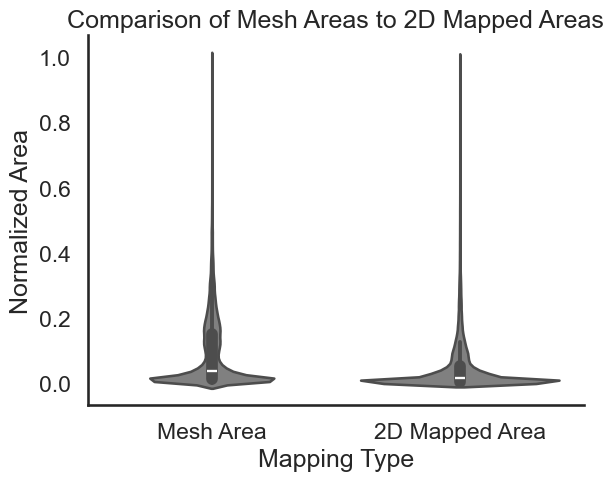

In [10]:
sns.violinplot(data=area_table.to_pandas(), x="Mapping Type",
              y="Normalized Area", color="grey")
sns.despine()
plt.title("Comparison of Mesh Areas to 2D Mapped Areas")

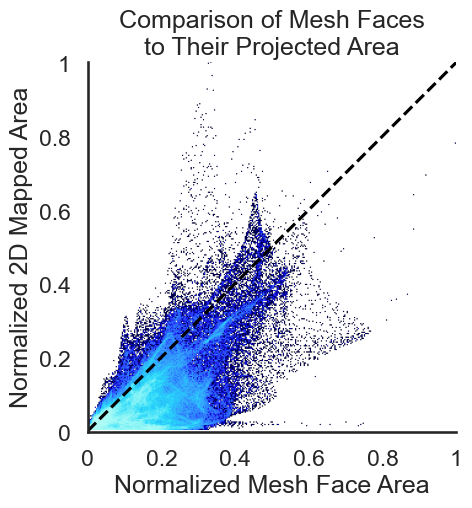

In [11]:
area_compare = pl.DataFrame({"Mesh Faces": mesh_areas / np.max(mesh_areas),
                             "2D Mapped Faces": uv_areas / np.max(uv_areas)})

agg = ds.Canvas(
    plot_width=300,
    plot_height=300,
    ).points(area_compare.to_pandas(), 'Mesh Faces', '2D Mapped Faces')
img = ds.tf.set_background(
    ds.tf.shade(agg, how="eq_hist",
                cmap=cc.CET_L6)).to_pil()
plt.gca().set_aspect('equal')
plt.imshow(img)
x = [0, 300]
y = [300, 0]
ax = sns.lineplot(x=x, y=y, color='k')
ax.lines[0].set_linestyle("--")
plt.xlim([0, 300])
plt.ylim([300, 0])
sns.despine()
plt.xticks(range(0, 301, 60), [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks(range(301, 0, -60), [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xlabel("Normalized Mesh Face Area")
plt.ylabel("Normalized 2D Mapped Area")
plt.title("Comparison of Mesh Faces\nto Their Projected Area", y=1)
plt.show()

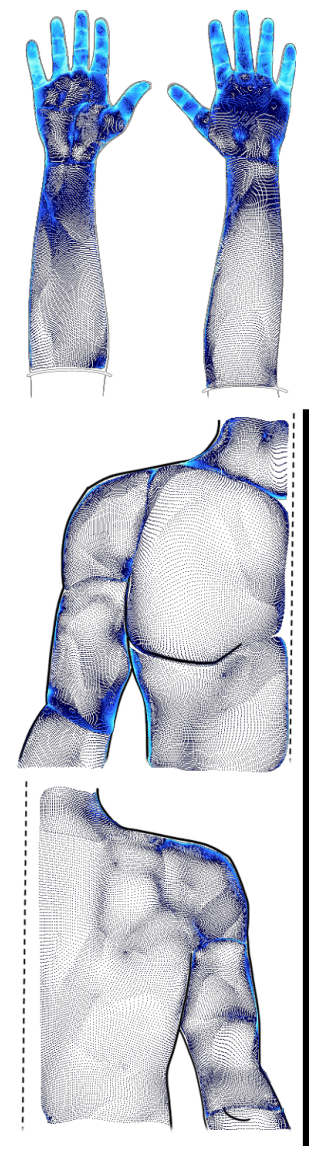

In [12]:
# Find the image dimensions
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name='config.yaml')
im = cv2.imread(cfg.drawing_templates.image, 1)
image_x_size = im.shape[1]
image_y_size = im.shape[0]
fig = plt.figure(figsize=(image_x_size/500, image_y_size/500))
scale = 5
im = cv2.resize(im, (round(image_x_size / scale), round(image_y_size / scale)))
plt.imshow(im)

uv_data = pl.DataFrame({"U": uv_array[:, 0],
                        "V": uv_array[:, 1]})

scale = 0.97
agg = ds.Canvas(
    plot_width=round(im.shape[1] * scale),
    plot_height=round(im.shape[0] * scale)
    ).points(uv_data.to_pandas(), 'U', 'V')
img = ds.tf.set_background(
    ds.tf.shade(agg, how="eq_hist",
                cmap=cc.CET_L6)).to_pil()
x_shift = 10
y_shift = 10
M = np.float32([
	[1, 0, x_shift],
	[0, 1, y_shift]
])
img = np.array(img)
img = cv2.resize(img, (round(img.shape[1] * 0.96),
                       round(img.shape[0] * 1.01)))

shifted = cv2.warpAffine(img, M, (img.shape[1] + x_shift,
                                  img.shape[0] + y_shift))
plt.imshow(shifted)
plt.xlim([0, im.shape[1]])
plt.ylim([im.shape[0] + y_shift, y_shift])
plt.axis('off')
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Image   [x,y]   (z)
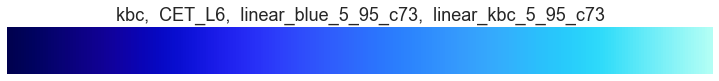

In [13]:
import holoviews as hv
hv.extension('matplotlib')
from colorcet.plotting import swatch

swatch("CET_L6")